In [41]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(export))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lsmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(multcomp))

# 1. Import data

#### metabolic cage

In [42]:
profile <- read.csv(file = "stat_corrected.csv", as.is = TRUE)
profile$Diet <- as.factor(profile$Diet)
profile$MouseID <- ordered(profile$MouseID)
profile$MouseID <- as.factor(profile$MouseID)

#### phenotypes

In [23]:
data <- read.csv("table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = LV_TAG * liver_wt,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces*fecal_tot_output, 
                          rest_fat = Fat_mass - lv_tot_tag/1000 - (TG_feces*fecal_tot_output)/1000 - plasma_TAG*58.5*(wt/1000)/(100*1000))#; head(data)

# 2. Set theme, import functions

In [27]:
mycolor <- c("black", "#0080ff", "#ffa500", "red", "darkgreen")
lines <- c("dashed", "solid", "solid", "solid", "solid")
shapes <- c(1, 24, 4, 15, 25)
theme_set(theme_bw())

In [31]:
Contrasts <- list(
    'TXN vs HFD' = c(0, -1, 0, 0, 1),
    'HXN vs HFD' = c(0, -1, 0, 1, 0),
    'LFD vs HFD' = c(1, -1, 0, 0, 0),
    'TXN vs LFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(0, -1, 1, 0, 0))

Contrasts1 <- list(
    'HFD vs LFD' = c(-1, 1, 0, 0, 0),
    'LXN vs LFD' = c(-1, 0, 1, 1, 0),
    'HXN vs LFD' = c(-1, 0, 0, 1, 0),
    'TXN vs LFD' = c(-1, 0, 0, 0, 1),
    'TXN vs HFD' = c(0, -1, 0, 0, 1))


median_RQ_lt <- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medRQ = median(RQ)) %>% filter(Cycle=="light")
median_RQ_dk<- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medRQ = median(RQ)) %>% filter(Cycle=="dark")

median_EE_lt <- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medEE = median(EE)) %>% filter(Cycle=="light")
median_EE_dk<- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medEE = median(EE)) %>% filter(Cycle=="dark")

In [71]:
.ci <-
function(x,conf.level=0.95) {
  tri <- sort(na.omit(x))
  if (any(!is.finite(tri))) {tri <- tri[-which(!is.finite(tri))]}
  repet <- length(tri)
  int <- (1-conf.level)/2
  if(repet*int<1) {
    int.inf <- ceiling(repet*int)
  } else {
    int.inf <- floor(repet*int)
  }
  int.sup <- ceiling(repet*(1-int))
  result <- c("Inf"=tri[int.inf],"Sup"=tri[int.sup])
  return(result)
}

spearman.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="spearman")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="spearman")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Spearman's rank correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

pearson.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="pearson")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="pearson")$estimate))
  names(coeff) <- "rho"
  result <- list(method="pearson correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

# 3. Plots 

## 3.1 Average energy expenditure

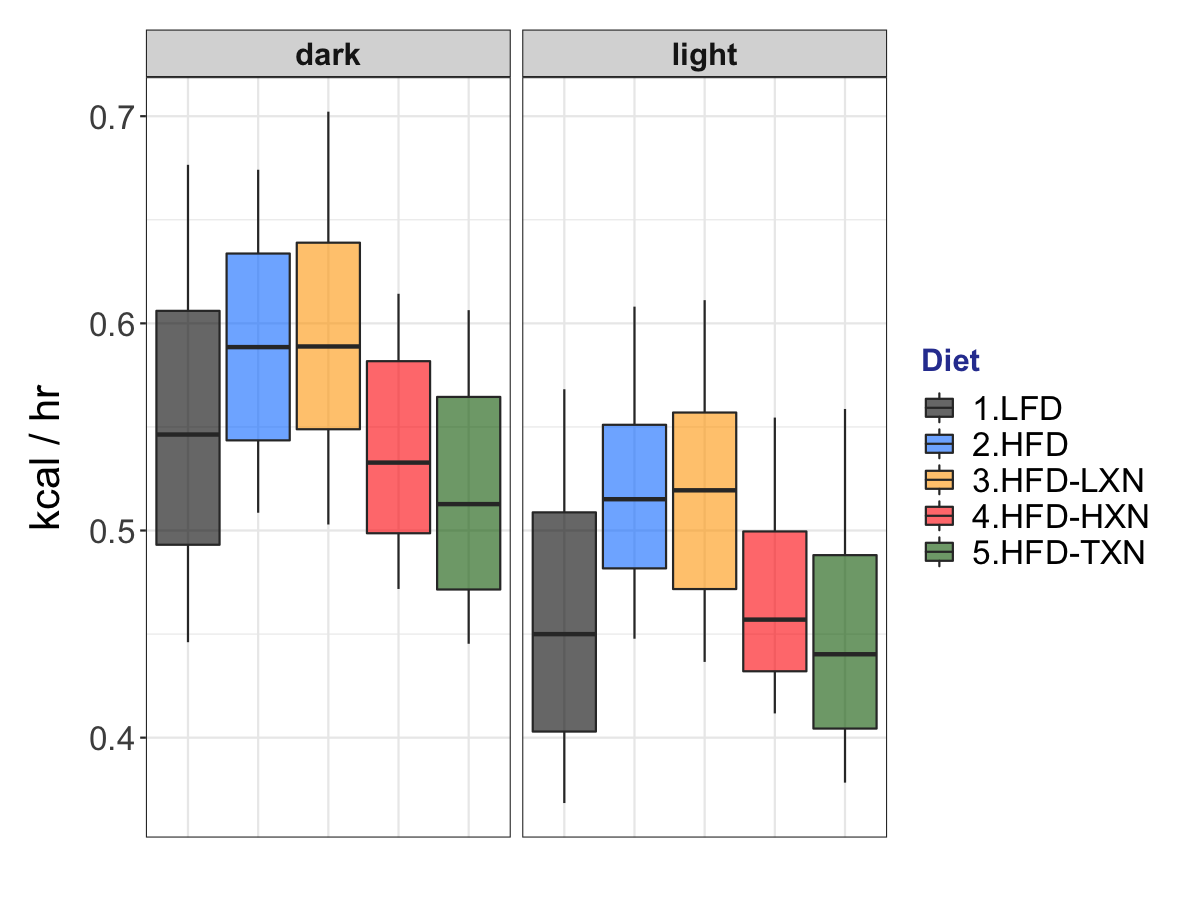

In [48]:
eebox <- profile %>% dplyr::select(1:5) %>% group_by(Diet, Cycle)

f <- function(x){
  r <- quantile(x, probs = c(0.10, 0.25, 0.5, 0.75, 0.90))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

o <- function(x){
  subset(x, x < quantile(x, probs = 0.1) | quantile(x, probs = 0.9) < x)
}

eeboxp <- ggplot(data=eebox, aes(x=Diet, y=EE, fill=Diet)) +
    stat_summary(fun.data = f, geom = "boxplot", position = "dodge") +
    scale_fill_manual(values = alpha(mycolor, .6)) +
    xlab("") + ylab("kcal / hr") +
    facet_grid(~ Cycle) 

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150)
(eeboxp <- eeboxp + 
    theme(axis.title.y = element_text(size = 20, margin = margin(t=0, r=10, b=0, l=0)),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_text(size = 15, face = "bold", colour = "#303F9F"),
          legend.text = element_text(size = 16),
          legend.position = "right",
          strip.text = element_text(size = 15, face = "bold"),
          plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm")))

## 3.2 Hourly energy expenditure

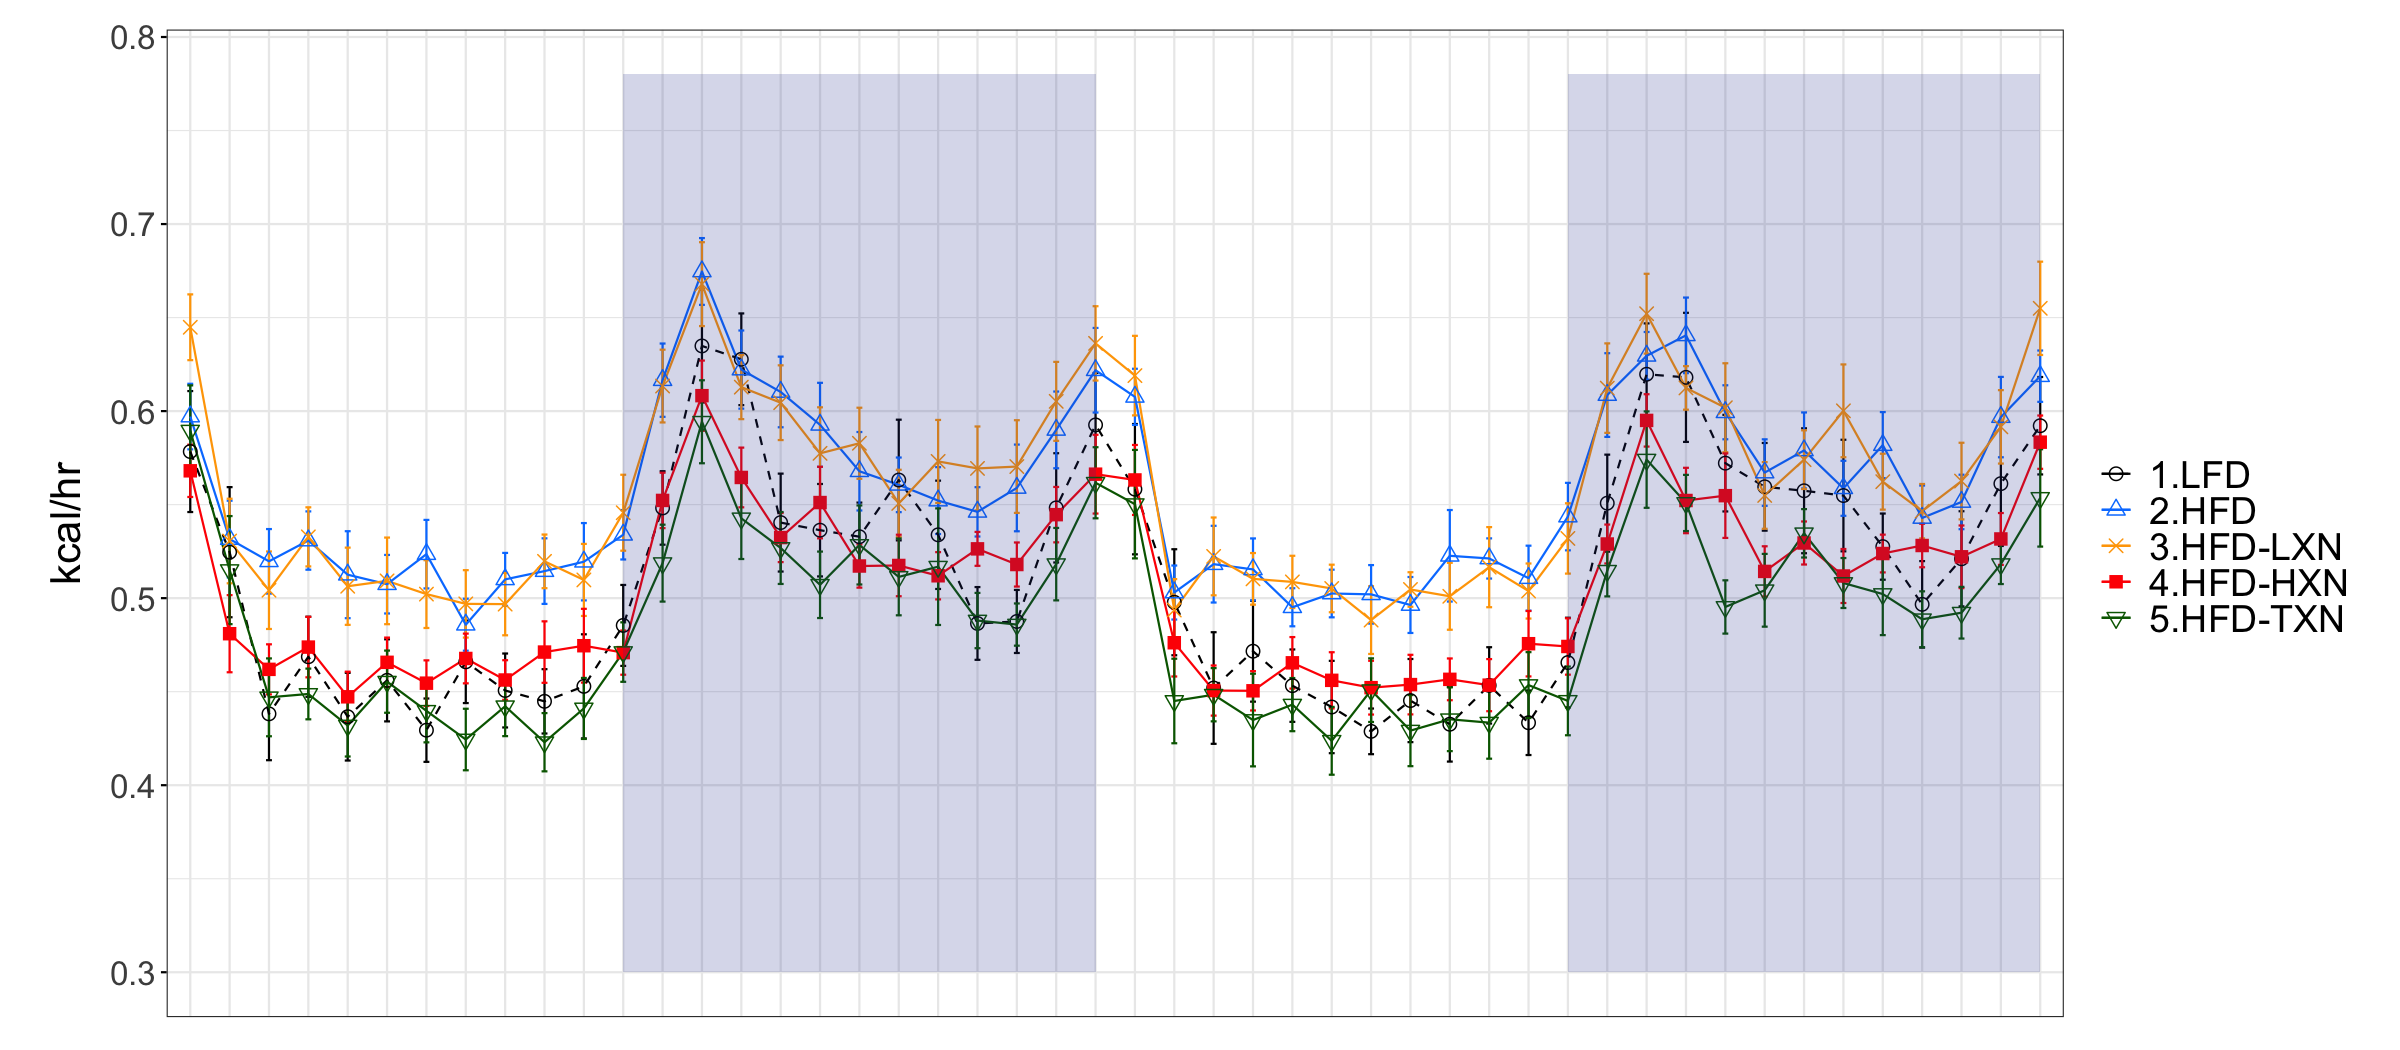

In [50]:
EE <- ggline(profile, x = "Time", y = "EE", group = "Diet",
       add = "mean_se", color = "Diet", palette = mycolor,
       ylab = "kcal/hr", xlab = "", 
       linetype = "Diet", shape = "Diet",
       point.size = 1.5,
       ggtheme = theme_bw())


EE <- EE + 
    annotate("rect", xmin="Cycle1:17:00-18:00", xmax="Cycle1:05:00-06:00", ymin=0.3, ymax=0.78, 
             alpha=0.2, fill="#303F9F") +
    annotate("rect", xmin="Cycle2:17:00-18:00", xmax="Cycle2:05:00-06:00", ymin=0.3, ymax=0.78, 
             alpha=0.2, fill="#303F9F")

options(repr.plot.width = 16, repr.plot.height = 7, repr.plot.res = 150)

(EE <- EE + scale_linetype_manual(values=c("dashed", "solid", "solid", "solid", "solid")) +  
    scale_shape_manual(values = shapes) +
    theme(axis.title.y = element_text(size = 20, margin = margin(t=0, r=10, b=0, l=10)),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_text(size = 15, face = "bold", colour = "white"),
          legend.text = element_text(size = 18),
          legend.position = "right",
          plot.margin = unit(c(0.5,0.5,0,0.5), "cm")))

In [22]:
#graph2pdf(EE, "EE.pdf", width = 16, height = 8)

# 4. Stats

## 4.1 Average energy expenditure

In [51]:
model_lt <- lm(medEE ~ Diet, data=median_EE_lt)
leastsquare <- lsmeans(model_lt, "Diet")
output <- contrast(leastsquare, Contrasts, adjust = "none")
print(output)

 contrast   estimate     SE df t.ratio p.value
 TXN vs HFD -0.07218 0.0212 54 -3.412  0.0012 
 HXN vs HFD -0.04972 0.0207 54 -2.403  0.0197 
 LFD vs HFD -0.05824 0.0207 54 -2.815  0.0068 
 TXN vs LFD -0.01393 0.0212 54 -0.659  0.5129 
 LXN vs HFD -0.00111 0.0207 54 -0.053  0.9575 



## 4.2 Correlations

> 4.1 shows that LFD, HXN and TXN had lower average energy expenditure compared to HFD mice. This makes intuitive sense because usually the larger the animal, the more energy is spent. I did a correlation analysis with total body weight just to see what it looks like. And I excluded LFD from this analysis.

In [74]:
dataHFD <- data %>%
filter(Treatment != "LFD")

In [75]:
dataHFD %>%
    summarise(r = pearson.ci(avgEE, wt)$estimate,
             pvalue = cor.test(avgEE, wt, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, wt)$conf.int[1],
             upper = pearson.ci(avgEE, wt)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6625921,3.905908e-07,0.52924,0.7834008


> A strong and significant positive correlation between total body weight and average energy expenditure.

In [76]:
dataHFD %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(avgEE, wt)$estimate,
             pvalue = cor.test(avgEE, wt, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, wt)$conf.int[1],
             upper = pearson.ci(avgEE, wt)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.7254564,0.007577621,0.4021262,0.9109864
HFD+LXN,0.3245957,0.303291183,-0.4148636,0.7481900
HFD+HXN,0.5903490,0.043293600,0.1630357,0.8150822
HFD+TXN,0.6401284,0.033882418,-0.1225383,0.8991974


> In general, the relationship holds true in HFD, HXN and TXN groups, except for LXN.

## 4.2 ANCOVA analysis on Average energy expenditure, controlling for total body weight

> Obviously, body weight is one of the key factors driving the rate of energy expenditure. Bigger mice have more metabolizing tissue and expend more energy. Even if a difference is detected in the rate of energy expenditure shown in 4.1, it may be a secondary effect of the altered body weight, rather than a primary effect of the treatment alone. My first thought was to normalize energy expenditure with body weight. After some researching, I realized that approach can be problematic, because the relationship between metabolic rate and body weight is seldom proportional.
> **Therefore, analysis of covariance, in my opinion, can give me the answer whether or not the treatment had any effect on the energy expenditure.**

ref: https://paperpile.com/app/p/ad2144a3-3bc8-0c95-acc5-27e3db62202a

In [77]:
fit = aov(avgEE~Treatment+wt, dataHFD)

In [78]:
Anova(fit, type="III")

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.015751092,1,9.927193,0.002999633
Treatment,0.008825554,3,1.854114,0.152108433
wt,0.024609603,1,15.510307,0.000303563
Residuals,0.066639771,42,NA,NA


In [79]:
summary(Anova(fit, type="III"))

     Sum Sq               Df           F value           Pr(>F)         
 Min.   :0.008826   Min.   : 1.00   Min.   : 1.854   Min.   :0.0003036  
 1st Qu.:0.014020   1st Qu.: 1.00   1st Qu.: 5.891   1st Qu.:0.0016516  
 Median :0.020180   Median : 2.00   Median : 9.927   Median :0.0029996  
 Mean   :0.028957   Mean   :11.75   Mean   : 9.097   Mean   :0.0518039  
 3rd Qu.:0.035117   3rd Qu.:12.75   3rd Qu.:12.719   3rd Qu.:0.0775540  
 Max.   :0.066640   Max.   :42.00   Max.   :15.510   Max.   :0.1521084  
                                    NA's   :1        NA's   :1          

In [80]:
posth = glht(fit, linfct=mcp(Treatment='Tukey'))
summary(posth)
emmeans(fit, ~ Treatment:wt)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = avgEE ~ Treatment + wt, data = dataHFD)

Linear Hypotheses:
                        Estimate Std. Error t value Pr(>|t|)
HFD+HXN - HFD == 0     -0.032575   0.016861  -1.932    0.228
HFD+LXN - HFD == 0      0.003722   0.016270   0.229    0.996
HFD+TXN - HFD == 0     -0.018409   0.020827  -0.884    0.811
HFD+LXN - HFD+HXN == 0  0.036297   0.016732   2.169    0.146
HFD+TXN - HFD+HXN == 0  0.014166   0.018489   0.766    0.867
HFD+TXN - HFD+LXN == 0 -0.022131   0.020519  -1.079    0.701
(Adjusted p values reported -- single-step method)


 Treatment   wt emmean     SE df lower.CL upper.CL
 HFD       47.6  0.540 0.0122 42    0.515    0.565
 HFD+HXN   47.6  0.507 0.0115 42    0.484    0.531
 HFD+LXN   47.6  0.544 0.0121 42    0.519    0.568
 HFD+TXN   47.6  0.522 0.0146 42    0.492    0.551

Confidence level used: 0.95 

In [82]:
fit2 = aov(avgEE~Treatment+Lean_mass+subq_wt+epi_wat+mesenteric_wt, dataHFD)

In [83]:
Anova(fit2, type="III")

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.008957363,1,7.6334443,0.008696930
Treatment,0.001949577,3,0.5538084,0.648650854
Lean_mass,0.012436809,1,10.5986204,0.002343872
subq_wt,0.004634963,1,3.9499046,0.053928766
epi_wat,0.004981428,1,4.2451618,0.046077937
mesenteric_wt,0.002749733,1,2.3433162,0.133893412
Residuals,0.045764027,39,NA,NA


# 5. Conclusions

**XN or TXN treatment did not change energy expenditure.**
From 4.2, when controlled for body weight, treatment no longer influences the energy expenditure. 